In [1]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from datetime import date, timedelta
from pandas import DataFrame
import sqlalchemy as sq
import pickle
import numpy as np 
import math
import time
import scipy as scipy
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from ggplot import *
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
from modelselector import EstimatorSelectionHelper
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

import gc

In [2]:
data=pd.read_csv('/data/pratik/tensor/datasets/ad_clean_2k_inp.csv',error_bad_lines=False)

In [3]:
data.head()

date      brand  article_type gender                      bag_id  \
0  20160616       109F       Dresses  Women            109FDressesWomen   
1  20160616       109F          Tops  Women               109FTopsWomen   
2  20160616       109F        Tunics  Women             109FTunicsWomen   
3  20160616  20Dresses     Backpacks  Women     20DressesBackpacksWomen   
4  20160616  20Dresses  Casual Shoes  Women  20DressesCasual ShoesWomen   

   qty_sold  live_styles  inventory  wgt_input_td  input_td_rm  \
0        10           21        805     30.000000    25.000000   
1         6           30       1020     30.000000    25.000000   
2         1            6        328     30.000000    25.000000   
3        32           29        243      2.283814     1.880600   
4        11           54        461     11.132075     9.408977   

         ...          vis_cannib_lag  vis_cannib_rm  brokenness_lag  \
0        ...                0.000000       0.093656        0.000000   
1        ...                0.134804       0.100514        0.095238   
2        ...                0.024372       0.099293        0.033333   
3        ...                0.053012       0.107379        0.000000   
4        ...                6.610454       1.204163        0.000000   

   brokenness_rm  freshness_lag  freshness_rm  vis_cannib_max  \
0       0.459555       0.400000      0.260074        0.031194   
1       0.458874       1.000000      0.402932        0.006790   
2       0.385714       1.000000      0.428906        0.014335   
3       0.242857       1.000000      0.571763        3.182424   
4       0.100000       0.034483      0.513197        0.111926   

   vis_cannib_mean  price_cannib_max  price_cannib_mean  
0         0.134804          0.962724           0.962724  
1         0.024372          1.070262           1.070262  
2         0.053012          0.955622           0.955622  
3         6.610454          0.108616           0.108616  
4         0.467595          0.377952           0.377952  

[5 rows x 45 columns]

In [4]:
lst=data[['brand','article_type','gender']].drop_duplicates().to_records(index=False).tolist()

In [4]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true,y_pred))) * 100

In [23]:
def get_best_model(lst):
    b=lst[0]
    a=lst[1]
    g=lst[2]
    ad=data[(data['brand']==b) & (data['article_type']==a) & (data['gender']==g) ]
    
    d=ad[['date','qty_sold','wgt_input_td','input_td_diff','lc_share_pltf','live_styles','presale_flag','postsale_flag','sessions','brokeness','freshness','index_month','index_week_year','index_week_month','index_day','similar_brands_max']]

    train, test= train_test_split(d, test_size=0.2, random_state=0)
    y_train = train.qty_sold
    X_train = train.drop(['qty_sold','date'],axis=1)

    y_test = test.qty_sold
    X_test = test.drop(['qty_sold','date'],axis=1)

    models1 = { 
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'XGBRegressor': XGBRegressor()
    }

    params1 = { 
        'LinearRegression': { },
        'RandomForestRegressor': { 'n_estimators':[50,100,200],'max_depth':[5,7,9,11], 'random_state':[0]},
        'GradientBoostingRegressor':  { 'n_estimators':[50,100,200],'max_depth':[5,7,9,11] ,'random_state':[0]},
        'XGBRegressor': { 'n_estimators':[50,100,200],'max_depth':[5,7,9,11] ,'random_state':[0], 'booster':['gbtree', 'gblinear'] }
    }

    mape_scorer=make_scorer(mape,greater_is_better=False)
    selection= EstimatorSelectionHelper(models1, params1)
    selection.fit(X_train,y_train, cv=10, n_jobs=-1,scoring=mape_scorer)
    gs_eval=selection.score_summary()
    gs_eval.reset_index(inplace=True)
    gs_eval.drop('index',axis=1,inplace=True)
    best_est=gs_eval.loc[0,'estimator']
    gs_eval

    filename=b+'-'+a+'-'+g
    test_est=selection.grid_searches[best_est].best_estimator_
    mp=mape(test_est.predict(X_test), y_test)
    print( 'Validation MAPE: %0.2f' %mp) 
    pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(test_est.predict(X_test),columns=['pred'])], axis=1)
    pred['ape']=np.abs((pred['pred'] - pred['qty_sold']) / np.maximum(pred['qty_sold'],pred['pred']))
    pred['ae']=(pred['pred'] - pred['qty_sold']) /  np.maximum(pred['qty_sold'],pred['pred'])
    pred['bag']=filename
    pred.to_csv('/data/pratik/tensor/validations/nonlinear_validations/'+filename+'.csv',index=False)
    with open('/data/pratik/tensor/tmp/'+filename+'.pkl', 'wb') as f:
                    pickle.dump(test_est, f)
    ret=pd.DataFrame({ 'Brand': b,'Article_type': a,'Gender':g,'mape':mp}, index=[filename])
    print b+a+g+': completed'
    return ret

In [ ]:
p = multiprocessing.Pool(10);

In [ ]:
fit_data=p.map(get_best_model, lst)
final = pd.concat(fit_data)

In [ ]:
mp=final.reset_index().reset_index()
bag_mape=mp[['level_0','mape']]
#bag_mape[bag_mape['mape']<100].plot(0,figsize=(30, 8))
bag_mape.plot(0,figsize=(30, 8))

Optimal number of features : 13


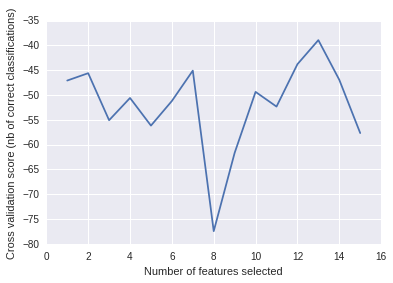

Index([u'live_styles', u'wgt_input_td', u'input_td_diff', u'brokeness',
       u'lc_share_pltf', u'postsale_flag', u'sessions', u'index_month',
       u'index_week_year', u'index_week_month', u'index_day',
       u'similar_brands_max', u'similar_brands_mean'],
      dtype='object')

In [22]:
from sklearn.svm import SVR,LinearSVR
from sklearn.feature_selection import RFECV

b='Libas'
a='Kurtas'
g='Women'

ad=data[(data['brand']==b) & (data['article_type']==a) & (data['gender']==g) ]

X=ad.drop(['date','brand','article_type','gender','qty_sold','inventory','input_td_rm','output_td_rm','output_td','output_td_diff','bag_id'],axis=1)
Y=ad[['qty_sold']]

mape_scorer=make_scorer(mape,greater_is_better=False)
# Create the RFE object and compute a cross-validated score.
svc = LinearSVR(C=0.5,tol=0.001)
#svc = SVR(kernel="linear")

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=5, scoring=mape_scorer,n_jobs=-1)
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
a=rfecv.get_support(indices=True)
X[a].columns